<center>
    <h1> INF510 - Advanced Computational Methods  </h1>
    <h2> Test #2 - Spectral Methods  </h2> 
</center>

* Martín Villanueva - `martin.villanueva@usm.cl` - **rol:** 201104012-0

_DI UTFSM. 2018._

In [1]:
%matplotlib inline

import numpy as np
import scipy as sp
import scipy.sparse.linalg
from numpy.fft import fft,ifft
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

from ipywidgets import interact, fixed
from ipywidgets import IntSlider, FloatSlider

### Helper functions

In [45]:
def cheb(N):
    if N==0:
        D=0.
        x=1.
        return D,x
    x = np.cos(np.pi*np.arange(N+1)/N)
    c=np.hstack((2,np.ones(N-1),2))*((-1.)**np.arange(N+1))
    X=np.tile(x,(N+1,1)).T
    dX=X-X.T
    D = np.outer(c,1./c)/(dX+np.eye(N+1))
    D = D - np.diag(np.sum(D.T,axis=0))
    return D,x

def surface_plot(xx, yy, vv, title=None, figsize=(13,6)):  
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(xx, yy, vv, linewidth=10, rstride=1, 
                    cstride=1, cmap='Blues', alpha=0.9)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('v')
    ax.view_init(elev=40., azim=300.)
    if title is not None:
        plt.title(title)
    plt.show()

def surface_plot_helper(xx, yy, usol, time, index):
    vv = usol[index]
    t = time[index]
    surface_plot(xx, yy, vv, title="Solution at t={0}".format(t))
    
def lines_plot(xgrid, tgrid, U, xlim=None, tlim=None, ulim=None, title=None, numli=20.):
    udata = list()
    tdata = list()
    
    delta = int(U.shape[0]/float(numli))
    for i in range(U.shape[0]):
        if i%delta != 0: continue
        tdata.append(tgrid[i])
        udata.append( zip(xgrid, U[i]) )

    fig = plt.figure(figsize=(12,6))
    ax = fig.gca(projection='3d')
    lc = LineCollection(udata)
    lc.set_alpha(0.5)
    ax.add_collection3d(lc, zs=tdata, zdir='y')
    ax.set_xlabel('x')
    ax.set_xlim3d(xlim)
    ax.set_ylabel('t')
    ax.set_ylim3d(tlim)
    ax.set_zlabel('u')
    ax.set_zlim3d(ulim)
    ax.view_init(elev=45., azim=245)
    plt.title(title)
    plt.show()

### Problem `#1`

#### `Part a)`

This problem consist of studying numerically the Laplace operator, i.e., we want to solve numerically equations like:

$$
\Delta u = u_{xx} + u_{yy} = f,
$$

with $f$ a given function. Written numerically, this problem consists of solving:

$$
\widetilde{D}_N^2 U + U (\widetilde{D}_N^2)^T = f(X,Y),
$$

where $u$ is the function evaluated in the 2D-Chebyshev grid, and in the same way $f(X,Y)$. This is the well-known __Sylvester equation__.   To address the problem in a more general way, we rewrite the equation as a __Lyapunov equation__: $AX+XA^T=B$, where $A = \widetilde{D}_{N}^{2}$, $B=f(X,Y)$ and $X$ is the unknown matrix.

We already know how to solve this matrix equation through the _Kronecker product trick_, which translates the problem to a linear system of equations of the form:

$$
\underbrace{\left( (I \otimes \widetilde{D}_N^{2}) + (\widetilde{D}_N^2 \otimes I) \right)}_{\mathbf{L}} \ \text{vec}(U) = \text{vec}(f(X,Y)).
$$

or written in a more the general way:

$$
\underbrace{\left( (I \otimes A) + (A \otimes I) \right)}_{\mathbf{L}} \ \text{vec}(X) = \text{vec}(B).
$$


The aim of this problem is to build a solution of the Sylvester equation without building $\mathbf{L}$ and based on GMRES. This because $\mathbf{L}$ has dimensions $N^2 \times N^2$, i.e., building it requires a huge amount of memory.

In first place we implement a function to solve the problem through Kronecker approach, which is implemented in the cell below:

In [3]:
def f(x,y):
    """
    Test function
    """
    return 10*np.sin(8*x*(y-1))

N = 32
D,x = cheb(N); D2 = np.dot(D,D)
D2 = D2[1:-1,1:-1]
x = x[1:-1]; y = np.copy(x)
xx,yy = np.meshgrid(x, y)
ff = f(xx,yy)

In [4]:
def sylvester_solver1(A,B):
    """
    Solution to Sylvester equation with the
    Kronecker trick
    """
    n = A.shape[0]
    I = np.identity(n)
    L = np.kron(I,A)+np.kron(A,I)
    b = np.ravel(B)
    x = np.linalg.solve(L, b)
    return np.reshape(x, (n,n)),L

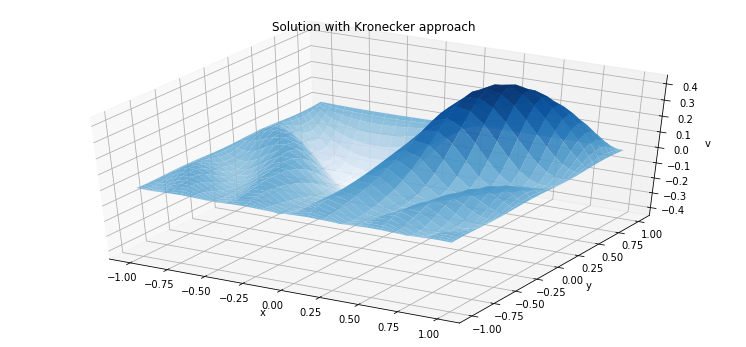

In [5]:
# Solution obtained with the first approach
U1,_ = sylvester_solver1(D2, ff)
surface_plot(xx,yy,U1, title="Solution with Kronecker approach")

***
Now for the GMRes approach, we need to solve the equation $\mathbf{L} \ \text{vec}(U) = \text{vec}(f(X,Y))$, without explicitly building $\mathbf{L}$. In the case of GMRes we only need to compute the product $\mathbf{L} \ \text{vec}(U)$ without building $\mathbf{L}$. This can be easily done noting that:
$$
\mathbf{L} \ \text{vec}(U) = \text{vec}(\widetilde{D}_N^2 U + U (\widetilde{D}_N^2)^T )
$$
so we use this operation every time GMRes needs to perform the product $\mathbf{L} \ \text{vec}(U)$. In the cell below is the corresponding __matrix-free__ implementation, with just two lines modified to the original GMRes algorithm.

In [6]:
def Lfun(A,x):
    U = x.reshape(A.shape, order="F")
    ret = np.dot(A,U)+np.dot(U,A.T)
    return ret.ravel(order="F")

def sylvester_solver2(A, B, m=100, threshold=1e-12):
    """
    Approximate solution to the Sylvester equation
    with GMRes
    
    GMRes code adapted from:
    https://github.com/tclaudioe/Scientific-Computing/blob/master/SC1/10_GMRes.ipynb
    """
    b = B.ravel()
    n = b.shape[0]
    x0 = np.zeros(n)
    r0 = b - Lfun(A, x0)  # matrix-free
    nr0 = np.linalg.norm(r0)
    Q = np.zeros((n,m+1))
    H = np.zeros((m+1,m))
    Q[:,0] = r0 / nr0
    flag_break=False
    for k in range(min((m,n))):
        y = Lfun(A, Q[:,k])  # matrix-free
        for j in range(k+1):
            H[j][k] = np.dot(Q[:,j], y)
            y = y - np.dot(H[j][k],Q[:,j])
        if k+1<n:
            H[k+1][k] = np.linalg.norm(y)
            if (np.abs(H[k+1][k]) > 1e-16):
                Q[:,k+1] = y/H[k+1][k]
            else:
                flag_break=True
            e1 = np.zeros((k+1)+1); e1[0]=1
            H_tilde=H[0:(k+1)+1,0:k+1]
        else:
            H_tilde=H[0:k+1,0:k+1]
        ck = np.linalg.lstsq(H_tilde, nr0*e1, rcond=None)[0] 
        if k+1<n:
            x = x0 + np.dot(Q[:,0:(k+1)], ck)
        else:
            x = x0 + np.dot(Q, ck)
        if flag_break:
            break
    return np.reshape(x, (int(np.sqrt(n)),int(np.sqrt(n)))), H, Q

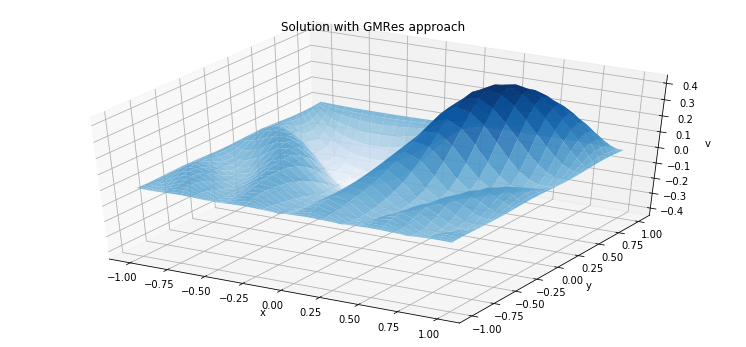

In [7]:
U2,H,Q = sylvester_solver2(D2,ff)
surface_plot(xx,yy,U2,title="Solution with GMRes approach")

***
In the cells below we study empirically the quality of the approximation obtained with GMRes versus the number of iterations needed, i.e., the size of the Krylov subspace used to approximate the solution.  

To achieve that we compute the residual between the solution obtained in `sylvester_solver1()` with the solution obtained with GMRes through the Frobenius norm, for different number of iterations `m`.

In [8]:
# Original solution
U1,_ = sylvester_solver1(D2, ff)
res = []

for m in range(10, 301, 10):
    U2,_,_ = sylvester_solver2(D2, ff, m=m)
    res.append( np.linalg.norm(U1-U2, ord="fro") )

As expected this residual decreases monotonically with the number of GMRes iterations. Wit
h `m=250` we get a F-residual norm of $\approx 10^{-8}$. For such reasons, in the next part of this problem we fix `m=250` to approximate the eigenvalues and eigenfunctions of $\mathbf{L}$.

It is worth mentioning the importance of these results: We get very accurate approximations solving a least squares problem of size $m\times m$ with $m \geq 150$, avoiding to solve the original linear system of size $N^2 \times N^2$, which in this case was $N=32$, i.e., $1024 \times 1024$. For a slightly finer grid, the linear system approach becomes unfeasible (by memory restrictions).

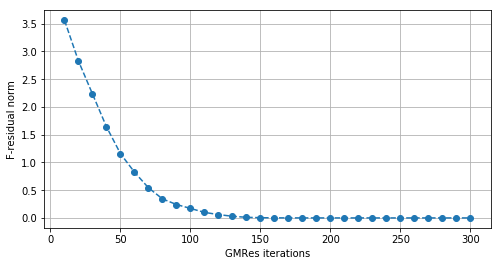

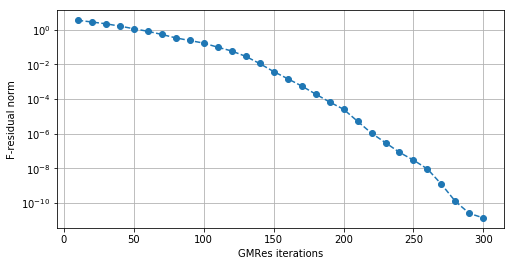

In [9]:
plt.figure(figsize=(8,4))
plt.plot(range(10, 301, 10), res, "o--")
plt.ylabel("F-residual norm")
plt.xlabel("GMRes iterations")
plt.grid()
plt.show()

plt.figure(figsize=(8,4))
plt.semilogy(range(10, 301, 10), res, "o--")
plt.ylabel("F-residual norm")
plt.xlabel("GMRes iterations")
plt.grid()
plt.show()

#### `Part b)`

Ritz eigenvectors (Eigenvectors of the Hessenberg matrix) are  approximations to the eigenvectors of a matrix $A$ that are obtained using the Arnoldi method. In GMRes we compute the Hessenberg matrix $H_k$ (square) and $Q_k$, the orthogonal basis of the Krylov space of size $k$. If $y$ is an eigenvector of the matrix $H_k$, then $V_k y$ is called the __Ritz eigenvector__ and approximate the eigenvectors of $\mathbf{L}$.

In the cell below we find approximations of the first $10$ eigenvalues and eigenfunctions of $\mathbf{L}$ with the method described above. We take the first eigenvalues and eigenvectors  of $H_k$, and then they are projected in the Krylov space of size $k$.

In [10]:
# Solution with Kronecker approach
U1,L = sylvester_solver1(D2,ff)
Lam1,V1 = sp.sparse.linalg.eigs(L, k=10, which="LM")
Lam1 = np.real(Lam1); V1 = np.real(V1)

In [11]:
# Solution with GMRes
U2,H,Q = sylvester_solver2(D2, ff, m=250)
dims = U2.shape
H_tilde = H[:-1,:]
Q = Q[:,:-1]
Lam2,V2 = sp.sparse.linalg.eigs(H_tilde, k=10, which="LM")
Lam2 = np.real(Lam2); V2 = np.real(V2)

For each case (Kronecker and GMRes) we compute the first $10$ eigenvectors with the largest corresponding eigenvalues (in magnitud). It happens that all eigenvalues are real negative numbers. In the cell below we plot them.

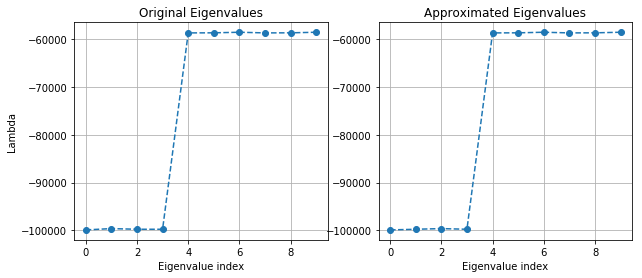

In [12]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(Lam1, 'o--')
plt.grid()
plt.ylabel("Lambda")
plt.xlabel("Eigenvalue index")
plt.title("Original Eigenvalues")
plt.subplot(1,2,2)
plt.plot(Lam2, 'o--')
plt.grid()
plt.xlabel("Eigenvalue index")
plt.title("Approximated Eigenvalues")
plt.show()

As you can see, the first four eigenvalues are very close in magnitude, but they are different. The same happens with the next six eigenvalues. 

Now, in the cell below we plot the first $10$ corresponding eigenfunctions of $\mathbf{L}$ and the approximations obtained with the ritz vectors from GMRes. For simplicity of visualization we don't plot them as surfaceplot but as a bidimensional projection (note that we lose the spatial notion of the Chebyshev grid). 

As you can see the eigenfunctions from GMRes approximate pretty well the real eigenfunctions of $\mathbf{L}$. It is important to mention that in some cases (like the 9-th eigenfunction)  differ in sign, but are essentially the same.

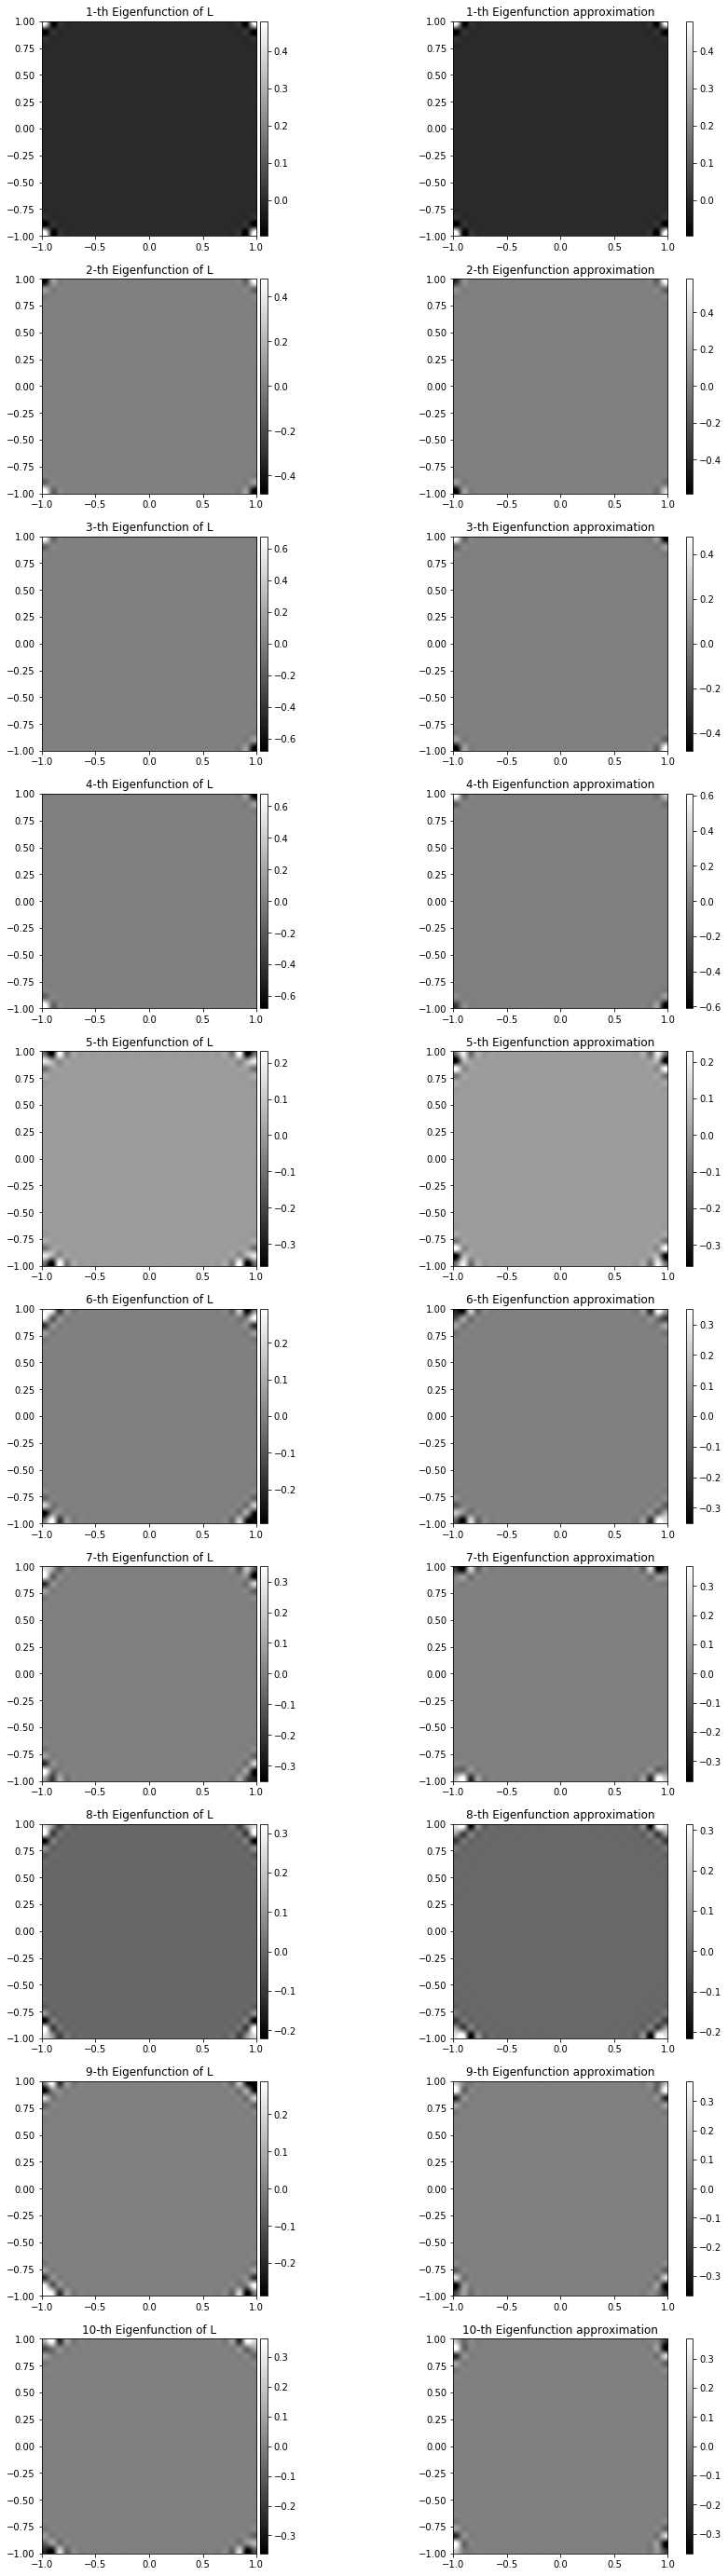

In [13]:
plt.figure(figsize=(15,50))
for i in range(10):
    plt.subplot(10,2,2*i+1)
    im = plt.imshow( V1[:,i].reshape(dims) ,cmap='gray', 
                    extent=[-1,1,-1,1], interpolation="spline16" )
    ax = plt.gca()
    plt.colorbar(im, ax=ax, pad=0.01, aspect=30)
    plt.title("{0}-th Eigenfunction of L".format(i+1))
       
    plt.subplot(10,2,2*(i+1))
    proy = np.dot(Q, V2[:,i])
    im = plt.imshow( proy.reshape(dims), cmap='gray', 
                    extent=[-1,1,-1,1], interpolation="spline16")
    ax = plt.gca()
    plt.colorbar(im, ax=ax, pad=0.05, aspect=30)
    plt.title("{0}-th Eigenfunction approximation".format(i+1))
plt.show()

#### References for `problem 1`

* https://en.wikipedia.org/wiki/Arnoldi_iteration#Finding_eigenvalues_with_the_Arnoldi_iteratiohttps://en.wikipedia.org/wiki/Arnoldi_iteration#Finding_eigenvalues_with_the_Arnoldi_iteratio`n
* Spectral Methods in Matlab, Lloyd N. Trefethen, Chapter 6

***
***
### Problem `#2`

In this problem we are encouraged to solve the wave equation in two space dimensions:

$$
u_{tt} = u_{xx} + u_{yy}, \ \ \ \ \ -1<x,y<1, \ \ t>0 \ \ u = 0 \ \text{on the boundary},
$$

with initial conditions: $u(x,y,0) = e^{-40\left( (x-0.4)^2 + y^2 \right)}$ and $u_t(x,y,0) = 0$. We are asked to solve numerically this problem with two methods: With _Fourier method_ emulating the `Program 20` implementation from the guide book, and with _Chebyshev method_ implementing it with optimized matrix operations.

As usual, to solve this PDE we use spectral differentiation in space and finite differences in time. For the second case, we use Chebyshev differentiation matrices to numerically approximate $u_{xx}+u_{yy}$ as follows:

$$u_{xx} \approx D_N^2 U \ \ \ \text{and} \ \ \ u_{yy} \approx U (D_N^2)^T$$

where $U$ is the matrix obtained when $u(x,y)$ is evaluated in the regular $xy$ Chebyshev grid. Below is the corresponding implementation which takes `N`, and solve this problem with the Chebyshev method in a grid of size `(N+1)x(N+1)`.

In [15]:
# Chebyshev method solver
def wave_equation_solver1(N):
    D,x = cheb(N); y = np.copy(x)
    D2 = np.dot(D,D)
    xx,yy = np.meshgrid(x,y)

    # initial condition
    uu = np.exp(-40*((xx-0.4)**2 + yy**2))
    uuold = uu

    # boundary conditions
    uu[0,:]=0; uu[-1,:]=0; uu[:,0]=0; uu[:,-1]=0

    # time stepping with leap-frog formula
    t = 1.0
    dt = (5.0)/(N**2)
    n_iter = int(t/dt)
    usol = np.zeros((n_iter,len(x),len(y)))
    usol[0,:,:] = uu
    
    for i in range(1,n_iter):
        uxx = np.dot(D2,uu)
        uyy = np.dot(uu,D2.T)
        uunew = 2*uu - uuold + (dt**2)*(uxx+uyy)
        # enforcing boundary conditions
        uunew[0,:]=0; uunew[-1,:]=0; uunew[:,0]=0; uunew[:,-1]=0
        uuold = uu
        uu = uunew
        usol[i,:,:] = uu
    
    return xx,yy,usol

In the cell below is presented the Python port to the Matlab code in `Program 20` of the guide book, which is based in the code available below in the question's reference.

In [16]:
# Fourier method solver
def wave_equation_solver2(N):
    x = np.cos(np.pi*np.arange(0,N+1)/N) 
    y = np.copy(x)    
    xx, yy = np.meshgrid(x,y)

    # initial condition
    vv = np.exp(-40*((xx-0.4)**2 + yy**2));
    vvold = vv

    # time stepping with leap-frog formula
    t = 1.0
    dt = (5.0)/(N**2)
    n_iter = int(t/dt)
    usol = np.zeros((n_iter,len(x),len(y)))
    usol[0,:,:] = vv

    for k in range(1,n_iter):
        uxx = np.zeros((N+1,N+1)); uyy = np.zeros((N+1,N+1));
        ii = np.arange(1,N);

        for i in range(1,N):
            v = vv[i,:];          
            V = list(v) + list(np.flipud(v[ii]));
            U = np.real(np.fft.fft(V));
            w1_hat = 1j*np.zeros(2*N);
            w1_hat[0:N] = 1j*np.arange(0,N)
            w1_hat[N+1:] = 1j*np.arange(-N+1,0)
            W1 = np.real(np.fft.ifft(w1_hat * U))
            w2_hat = 1j*np.zeros(2*N);
            w2_hat[0:N+1] = np.arange(0,N+1)
            w2_hat[N+1:] = np.arange(-N+1,0)
            W2 = np.real(np.fft.ifft((-w2_hat**2) * U))
            uxx[i,ii] = W2[ii]/(1-x[ii]**2) - (x[ii]*W1[ii])/(1-x[ii]**2)**(3.0/2);
        for j in range(1,N):
            v = vv[:,j]; 
            V = list(v) + list(np.flipud(v[ii]));
            U = np.real(np.fft.fft(V))
            w1_hat = 1j*np.zeros(2*N);
            w1_hat[0:N] = 1j*np.arange(0,N)
            w1_hat[N+1:] = 1j*np.arange(-N+1,0)
            W1 = np.real(np.fft.ifft(w1_hat * U))
            w2_hat = 1j*np.zeros(2*N);
            w2_hat[0:N+1] = np.arange(0,N+1)
            w2_hat[N+1:] = np.arange(-N+1,0)
            W2 = np.real(np.fft.ifft(-(w2_hat**2) * U))
            uyy[ii,j] = W2[ii]/(1-y[ii]**2) - y[ii]*W1[ii]/(1-y[ii]**2)**(3.0/2.0);
        vvnew = 2*vv - vvold + dt**2 *(uxx+uyy)
        vvold = vv
        vv = vvnew
        usol[k,:,:] = vv
    return xx,yy,usol

To make fair comparisons we use the same time-step and ODE solver (leap frog) in both methods, for time $0\leq t \leq 1$.

#### Time benchmarks

Below we present time bechmarks for both implementations (Chebyshev and Fourier, respectively) for different grid sizes, $N=24,48,96,192$.

In [17]:
# Chebyshev method benchmarks
t1 = %timeit -o wave_equation_solver1(24)
t2 = %timeit -o wave_equation_solver1(48)
t3 = %timeit -o wave_equation_solver1(96)
t4 = %timeit -o wave_equation_solver1(192)
chebyshev_times = [t1.best, t2.best, t3.best, t4.best]

100 loops, best of 3: 3.74 ms per loop
10 loops, best of 3: 29.2 ms per loop
1 loop, best of 3: 471 ms per loop
1 loop, best of 3: 10.3 s per loop


In [18]:
# Fourier method benchmarks
t1 = %timeit -o wave_equation_solver2(24)
t2 = %timeit -o wave_equation_solver2(48)
t3 = %timeit -o wave_equation_solver2(96)
t4 = %timeit -o wave_equation_solver2(192)
fourier_times = [t1.best, t2.best, t3.best, t4.best]

1 loop, best of 3: 796 ms per loop
1 loop, best of 3: 8.82 s per loop
1 loop, best of 3: 1min 25s per loop
The slowest run took 6.06 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 14min 50s per loop


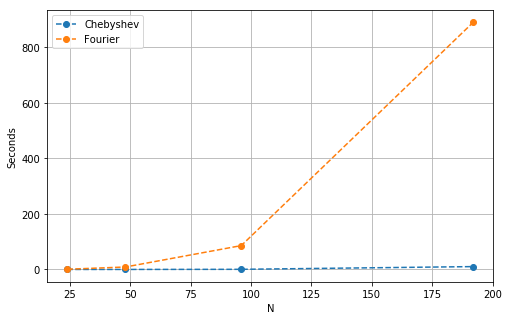

In [27]:
plt.figure(figsize=(8,5))
plt.plot([24,48,96,192], chebyshev_times, "o--", label="Chebyshev")
plt.plot([24,48,96,192], fourier_times, "o--", label="Fourier")
plt.grid()
plt.xlabel("N")
plt.ylabel("Seconds")
plt.legend(loc="best")
plt.show()

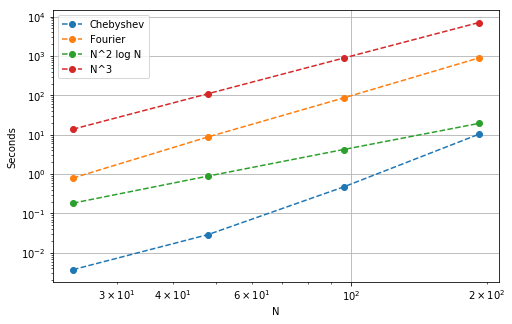

In [43]:
N = np.array([24,48,96,192])
N3 = 1e-3*N**3
N2logN = 1e-4*N**2*np.log(N)
plt.figure(figsize=(8,5))
plt.loglog([24,48,96,192], chebyshev_times, "o--", label="Chebyshev")
plt.loglog([24,48,96,192], fourier_times, "o--", label="Fourier")
plt.loglog([24,48,96,192], N2logN, "o--", label="N^2 log N")
plt.loglog([24,48,96,192], N3, "o--", label="N^3")
plt.grid()
plt.xlabel("N")
plt.ylabel("Seconds")
plt.legend(loc="best")
plt.show()

**Time Complexity Analysis**

For the time analysis we will only consider the operations of mayor complexity order inside the loop of the ODE solver. In the case of __Chebyshev method__, there are two matrix-matrix multiplications inside the loop plus other less relevant operations. This give us a time complexity of $O(N^3)$. In the case of __Fourier method__, in each time iteration the FFT and IFFT are applied through rows (complexity $O(N^2 \log N)$) and then through columns (complexity $O(N^2 \log N)$), plus other less relevant operations. This give us a time complexity of $O(N^2 \log N)$.

In the resulting plots above you can see the empirical times obtained. For low values of $N$ it happens that Chebyshev method is much more faster than Fourier's one. However, from the `loglog` plot you can see that the time curve of the Chebyshev method is steeper than the one obtained with the Fourier method. By comparing with the reference curves $N^2 \log N$ and $N^3$ you can see that the results obtained are approximations from what we derived in the theoretical complexity analysis.


#### Outputs comparison

Below we show the output comparisons for both methods with $N=96$ in a interactive widget, so it is possible to compare the outputs at the same times. As you can see, there are no appreciable differences between both solutions.

In [35]:
xx1,yy1,usol1 = wave_equation_solver1(96)
xx2,yy2,usol2 = wave_equation_solver2(96)
time = np.linspace(0., 1., usol1.shape[0])

In [46]:
# Chebyshev solution
interact(surface_plot_helper, xx=fixed(xx1), yy=fixed(yy1), usol=fixed(usol1), 
         time=fixed(time), index=IntSlider(min=0,max=1842,step=10,value=0));

interactive(children=(IntSlider(value=0, description=u'index', max=1842, step=10), Output()), _dom_classes=('widget-interact',))

In [47]:
# Fourier solution
interact(surface_plot_helper, xx=fixed(xx2), yy=fixed(yy2), usol=fixed(usol2), 
         time=fixed(time), index=IntSlider(min=0,max=1842,step=10,value=0));

interactive(children=(IntSlider(value=0, description=u'index', max=1842, step=10), Output()), _dom_classes=('widget-interact',))

#### References for Question `#2`
* http://nbviewer.jupyter.org/github/cpraveen/chebpy/blob/master/p20.ipynb
* Spectral Methods in Matlab, Lloyd N. Trefethen, Chapter 8, Program 20

***
***
### Problem `#3`


The equation we want to solve corresponds to the _Burgers equation_ which takes the form:

$$
u_t + (u^2)_{x} = \epsilon u_{xx} \ \ \ \ \ \text{with IC: } \ \ u(x,0) = \begin{cases} \sin^2(x)  \ \ \ x \in [-\pi,0] \\ 0 \ \ \ \ \ \ \ \ \ \ \ \  x \in \ (0,\pi] \end{cases}
$$

which is a combination of a nonlinear hyperbolic term $(u^2)_x$ and a linear dispersive term $u_{xx}$, whose influece is controlled by the $\epsilon$ parameter.


We follow the approach of integrating factors, by first applying the fourier transform in the spatial domain with the aim of obtaining a more tratable problem:

\begin{align}
\widehat{u_t} + i k \widehat{u^2} - \epsilon (ik)^2 \widehat{u} &= 0 \ \ \ \ \ / \cdot e^{-\epsilon (ik)^2 t} \\
\widehat{u_t} e^{-\epsilon (ik)^2 t} + i k \widehat{u^2} e^{-\epsilon (ik)^2 t} - \epsilon (ik)^2 \widehat{u} e^{-\epsilon (ik)^2 t} &= 0
\end{align}

Now, if we define $\widehat{U} = e^{-\epsilon(ik)^2 t} \widehat{u}$ and notice that deriving it respect to time gives: $\widehat{U}_t = -\epsilon (ik)^2 \widehat{U} + e^{-\epsilon(ik)^2 t} \widehat{u}_t$, we can replace it in the previous equation obtaining:

\begin{align}
\widehat{U}_t + ik e^{-\epsilon (ik)^2 t} \widehat{u^2} &= 0 \\
\widehat{U}_t &= - ik e^{-\epsilon (ik)^2 t} \widehat{u^2} \\
\widehat{U}_t &= - ik e^{-\epsilon (ik)^2 t} \mathcal{F}\left( \mathcal{F}^{-1}\left(e^{\epsilon (ik)^2 t} \widehat{U}\right)^2 \right)
\end{align}

The last equation is much more simple (is an ODE) and the influence of the linear term (the one with high frequency) is gone. The procedure now consists of solving the system of ODEs in the _fourier space_ (frequency domain) with a numerical integration method (method of lines). The algorithm works as follows:

1. Map the initial condition to the Fourier space with the corresponding integrating factor: $\widehat{U_0} = e^{-\epsilon (ik)^2 t} \widehat{u_0}$.
2. Run an ODE solver over $\widehat{U}_t = - ik e^{-\epsilon (ik)^2 t} \widehat{u^2}$.
3. The get the solution in the original space compute the inverse Fourier transform of $\displaystyle \widehat{U}_{\text{final}}$: $\ \ \ \ u = \mathcal{F}^{-1}(e^{ik^3 t_{\text{final}}} \widehat{U})$.

In the two cells below, you can see the corresponding implementation, which uses the RK4 for time integration. In order to make fair comparisons we use `dt=0.1` and `tmax=3` in all the runs.  

In [48]:
def burgers_equation_solver(N, eps):
    # x-grid
    xgrid = np.linspace(-np.pi, np.pi, N)
    # initial conditions
    u0 = np.zeros(N)
    u0[0:N//2] = np.sin(xgrid[0:N//2])**2 
    v = np.fft.fft(u0)
    # wave numbers
    k = np.concatenate((np.arange(0,N/2), np.array([0]), np.arange(-N/2+1,0,1)))

    # ode solver parameters
    dt = 0.1
    t = 0.
    tmax = 3.
    n_iter = int(round(tmax/dt))
    time_grid = np.linspace(0., tmax, n_iter+1)

    # solution array
    U = np.empty((n_iter+1, len(u0)))
    U[0] = u0
    
    ik2 = (1j*k)**2
    E = np.exp(eps*ik2*dt/2); E2 = E**2
    g = -1j*k*dt
    
    # solution with RK4's method
    for i in range(1, n_iter+1):
        k1 = g * np.fft.fft( np.real( np.fft.ifft( v ) )**2 )
        k2 = g * np.fft.fft( np.real( np.fft.ifft( E*(v + k1/2) ) )**2 )
        k3 = g * np.fft.fft( np.real( np.fft.ifft( E*v + k2/2 ) )**2 )
        k4 = g * np.fft.fft( np.real( np.fft.ifft( E2*v + E*k3 ) )**2 )
        v = E2*v + (E2*k1 + 2*E*(k2+k3) + k4)/6
        # we just store the solution at the original (spatial) domain
        U[i] = np.real( np.fft.ifft(v) )
    return xgrid,time_grid,U

#### Solution for `N=64`

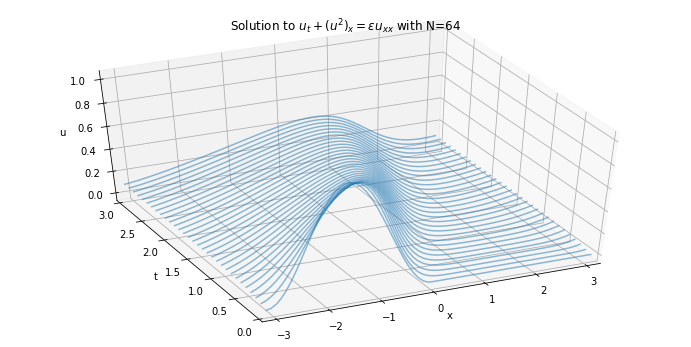

In [49]:
xgrid1,time_grid1,U1 = burgers_equation_solver(64, 0.25)
lines_plot(xgrid1, time_grid1, U1, 
           xlim=(-np.pi, np.pi), tlim=(0,3), 
           ulim=(U1.min()-0.05,U1.max()+0.05),
          title='Solution to $u_t + (u^2)_x = \epsilon u_{xx}$ with N=64')

#### Solution for `N=128`

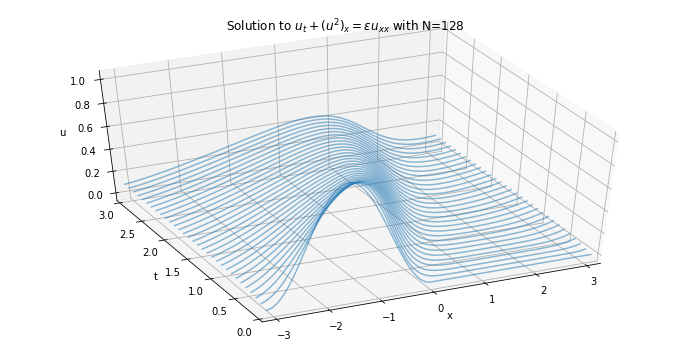

In [50]:
xgrid2,time_grid2,U2 = burgers_equation_solver(128, 0.25)
lines_plot(xgrid2, time_grid2, U2, 
           xlim=(-np.pi, np.pi), tlim=(0,3), 
           ulim=(U2.min()-0.05,U2.max()+0.05),
          title='Solution to $u_t + (u^2)_x = \epsilon u_{xx}$ with N=128')

#### Solution for `N=256`


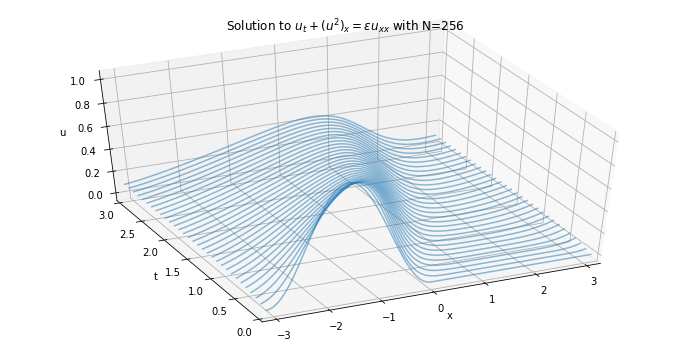

In [51]:
xgrid3,time_grid3,U3 = burgers_equation_solver(256, 0.25)
lines_plot(xgrid3, time_grid3, U3, 
           xlim=(-np.pi, np.pi), tlim=(0,3), 
           ulim=(U3.min()-0.05,U3.max()+0.05),
          title='Solution to $u_t + (u^2)_x = \epsilon u_{xx}$ with N=256')

As you can see, for all the values of `N` we obtain a very good approximations to the PDE solution. The initial wave move to the right and also disperses over the space as times goes on.

#### Varying $\epsilon$ to the unphysical oscillations limit

To find the $\epsilon$ value which leads to unphysical oscillations in the solution, we develop an interactive `IPython` widget that allows us to get a solution for a given value of $\epsilon$.

In [52]:
def _helper(eps):
    xgrid,time_grid,U = burgers_equation_solver(256, eps)
    lines_plot(xgrid, time_grid, U, 
               xlim=(-np.pi, np.pi), tlim=(0,3), 
               ulim=(U3.min()-0.05,U3.max()+0.05),
              title='Solution to $u_t + (u^2)_x = \epsilon u_{xx}$ with N=256')

In the widget below you can interactively decrease the value of $\epsilon$ seeing the effect it produces in the solution. As you can test, as we decrease $\epsilon$ the interface between the flat surface and the moving wave becomes steeper, and starting at $\epsilon \approx 0.032$ unphysical oscillations are observed. At $\epsilon \approx 0.028$ the simulation crashes. Note that this could be further improved with a finer grid. 

In [59]:
interact(_helper, eps=FloatSlider(min=0.01, max=0.25, step=0.001, value=0.25, readout_format='.5f'));

interactive(children=(FloatSlider(value=0.25, description=u'eps', max=0.25, min=0.01, readout_format=u'.5f', step=0.001), Output()), _dom_classes=('widget-interact',))

#### References for problem `#3`
* Spectral Methods in Matlab, Lloyd N. Trefethen, Chapter 10, Program 27


***
***
***

### Problem `#4`

In this problem we are encouraged to study numerically the operator $K$ defined by the following integro-differential equation:

$$
K u = -u''(x) + 4 \pi^2 \int_{0}^1 u(s)ds  \ \ \ \ \ \ \ \text{with} \ \ u(0)=u(1)=0.
$$

***

#### `part a)`

To build a numerical approximation of the $K$ operator, we need to build numerical approximations for the differential and integral parts.

where $\widetilde{D}_{N}$ is the Chebyshev differentiation matrix. 


For the integral term is a little more complicated. First of all, we will rewrite the integral in a more convenient way, using the following property:

$$
\int_a^b f(x) dx = \int_{-1}^{1} \underbrace{f\left( \frac{(b-a)t +a+b}{2} \right)}_{g(t)} \frac{b-a}{2} dt = \frac{b-a}{2} \int_{-1}^{1} g(t) dt,
$$

then, we can write the integral term as:

$$
4\pi^2 \int_{0}^{1} u(s) ds = 4 \pi^2 \int_{-1}^{1} u\left(\frac{s+1}{2} \right) \frac{ds}{2} = 2 \pi^2 \int_{-1}^{1} \underbrace{u\left(\frac{s+1}{2} \right)}_{g(s)} ds,
$$

and then, we can approximate this numerically with the Clenshaw-Curtis quadrature:

$$
2 \pi^2 \int_{-1}^{1} g(s) ds \approx 2 \pi^2 \sum_{i=0}^N w_i g(x_i) = 2 \pi^2 \sum_{i=0}^N  w_i u\left( \frac{x_i+1}{2} \right),
$$

where $x_i$ are the quadrature nodes (Chebyshev points) and $w_i$ the quadrature weights.




Since we are interested in $u$ over $x \in [0,1]$, we need to do some arrangements to compute the differential part. If we define $x = (\epsilon+1)/2$ with $\epsilon \in [-1,1]$, then

$$
\frac{d}{dx} u(x) = \frac{d}{dx} u\left( \frac{\epsilon+1}{2} \right) = \frac{d}{d\epsilon} u\left( \frac{\epsilon+1}{2} \right)  \frac{d\epsilon}{dx} = 2 \frac{d}{d\epsilon} \underbrace{u\left( \frac{\epsilon+1}{2} \right)}_{g(\epsilon)}.
$$


Let's call $v$ to the vector obtained obtained when we evaluate $u\left( \frac{x_i+1}{2} \right)$ with $x_i$ as the Chebyshev points. Also let's call $w$ to the vector of weights of the quadrature and $W$ to the matrix whose rows are the vectors $w$ `[1:N-1]` (without the first and last value). Since the integral term doesn't depend on $x$, we can write the numerical approximation as:

$$
K v \approx -4 \widetilde{D}_{N}^{2} \ v + 2 \pi^2 W_N \ v = (-4 \widetilde{D}_{N}^{2} + 2 \pi^2 W_N) \ v
$$

So the numerical approximation of $K \approx -4 \widetilde{D}_{N}^{2} + 2 \pi^2 W_N$, where $\widetilde{D}_{N}^{2}$ is the Chebyshev differentiation matrix of size $N$, and $W_N$ is the matrix of quadrature weights of size $N$. 

***

#### `part b)`

The codes of the two cells below build the numerical approximation of the operator $K$ as described above.



In [154]:
def clencurt(N):
    """
    Code obtained from:
    https://github.com/mikaem/spmpython/blob/master/clencurt.py
    """
    theta = np.pi*np.arange(0,N+1)/N
    x = np.cos(theta)
    w = np.zeros(N+1)
    ii = np.arange(1,N)
    v = np.ones(N-1)
    if N%2==0:
        w[0] = 1./(N**2-1)
        w[N] = w[0]
        for k in np.arange(1,int(N/2.)):
            v = v-2*np.cos(2*k*theta[ii])/(4*k**2-1)
        v = v - np.cos(N*theta[ii])/(N**2-1)
    else:
        w[0] = 1./N**2
        w[N] = w[0]
        for k in np.arange(1,int((N-1)/2.)+1):
            v = v-2*np.cos(2*k*theta[ii])/(4*k**2-1)
    w[ii] = 2.0*v/N
    return x, w

In [155]:
def K_approx(N):
    """
    Numerical approximation to the operator K
    """
    D,x = cheb(N+1); D2 = np.dot(D,D)
    D2 = D2[1:-1,1:-1]
    _,w = clencurt(N+1)
    w = w[1:-1]
    return -4*D2 + (2*np.pi**2)*w, (x[1:-1]+1)/2

Now we build a numerical approximation of $K$ of size $N=64$ and compute its first $5$ most significant eigenvalues and eigenfunctions approximations, and plot them accordingly. As you can see, the most significant eigenfunctions are the ones with high frequency at the limits of the $[0,1]$ interval. 

In [96]:
K,x = K_approx(64)
Lam,V = sp.sparse.linalg.eigs(K, k=5, which="LM")
Lam = np.real(Lam); V = np.real(V)

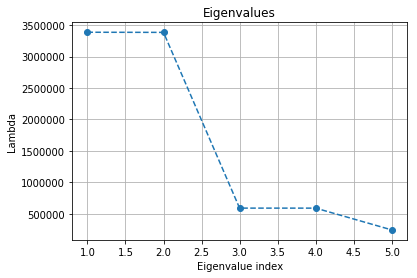

In [105]:
plt.figure(figsize=(6,4))
plt.plot([1,2,3,4,5], Lam, 'o--')
ax.set_xticks([1, 2, 3, 4, 5])
plt.grid()
plt.ylabel("Lambda")
plt.xlabel("Eigenvalue index")
plt.title("Eigenvalues")
plt.show()

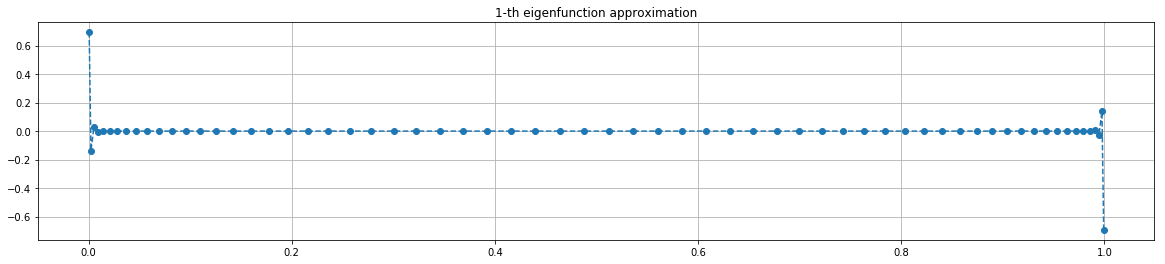

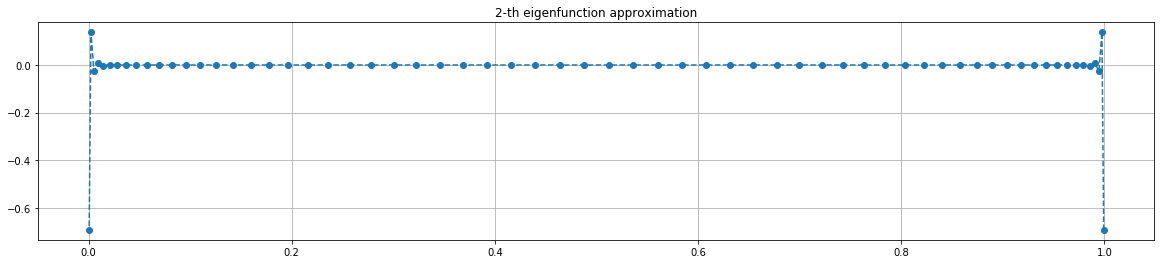

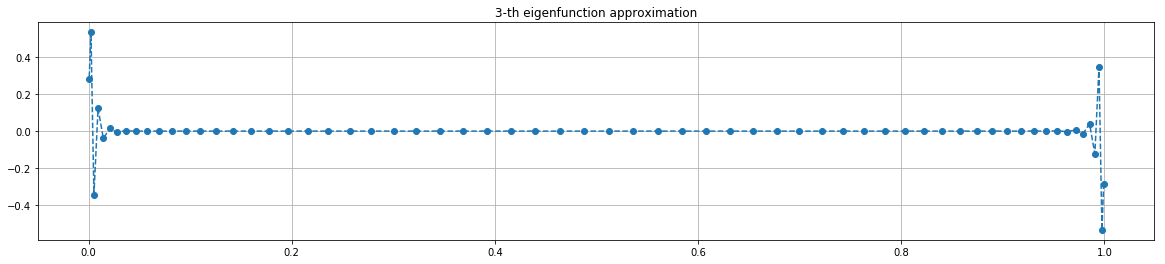

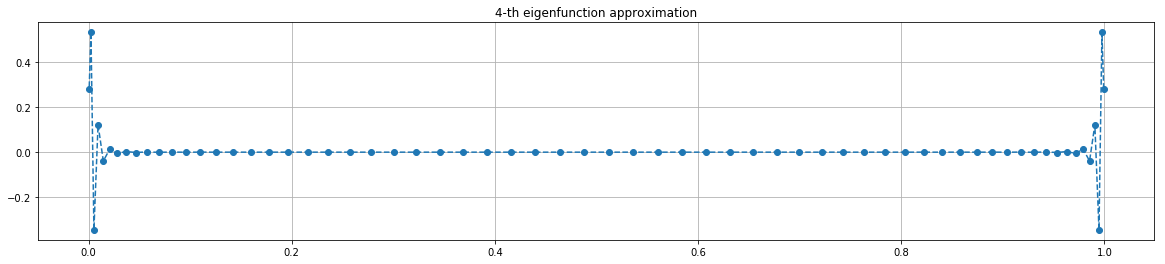

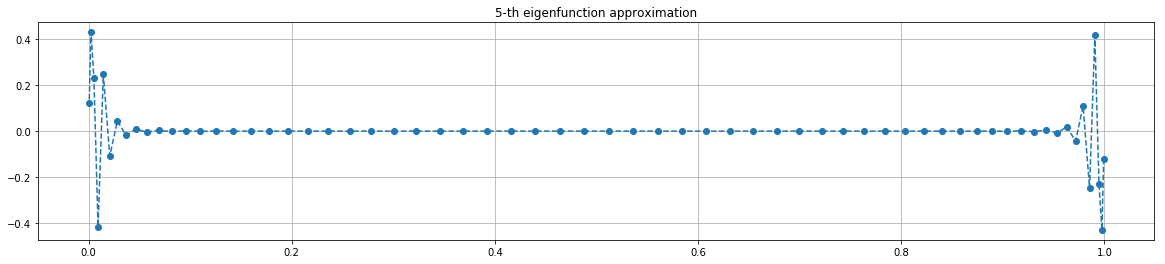

In [97]:
for i in range(5):
    plt.figure(figsize=(20,4))
    plt.plot(x, V[:,i], "o--")
    plt.grid()
    plt.title("{0}-th eigenfunction approximation".format(i+1))
    plt.show()

#### `part c)`

Finally we want to solve numerically the integro-differential equation $K u = \exp(x)\sin(x)$ with $u(0)=u(1)=0$. This can be done if and only if, $K$ is a nonsingular matrix.

So in first place, we will build the numerical approximation of the $K$ operator for different values of $N$, and plot its condition number.

In [126]:
cond_list = []
sizes = np.arange(32, 2048, 128)
for i in sizes:
    K,_ = K_approx(i)
    cond = np.linalg.cond(K)
    cond_list.append(cond)
    print("N={0} gives kappa={1}".format(i, cond))

N=32 gives kappa=5884.57501914
N=160 gives kappa=3316753.13761
N=288 gives kappa=34429706.5956
N=416 gives kappa=149234880.455
N=544 gives kappa=435417687.313
N=672 gives kappa=1012458816.87
N=800 gives kappa=2031634235.88
N=928 gives kappa=3676015188.18
N=1056 gives kappa=6160468194.89
N=1184 gives kappa=9731655053.99
N=1312 gives kappa=14668032840.5
N=1440 gives kappa=21279853906.9
N=1568 gives kappa=29909165882.2
N=1696 gives kappa=40929811674.1
N=1824 gives kappa=54747429464.3
N=1952 gives kappa=71799452709.9


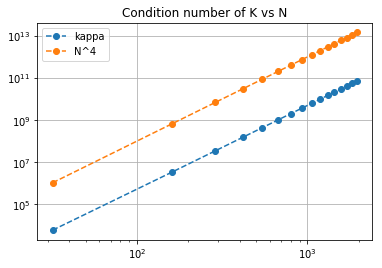

In [130]:
plt.loglog(sizes, cond_list, "o--", label="kappa")
plt.loglog(sizes, sizes**4, "o--", label="N^4")
plt.title("Condition number of K vs N")
plt.grid()
plt.legend(loc="best")
plt.show()

From the previous analysis we can see that the condition number grows with the size of $K$ like $\sim N^4$. However, the matrix is nonsingular and therefore we can solve the problem. 

In the next cells below we solve the problem for $N=32$ and $N=64$, making sure to add the boundary conditions after solving the linear system of equations.

In [131]:
def rhs(x):
    return np.exp(x)*np.sin(x)

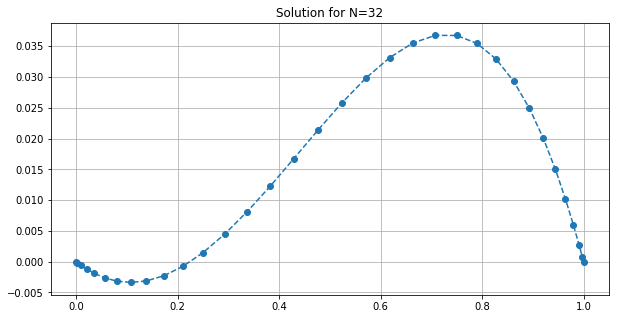

In [152]:
N = 32
K,x = K_approx(N)
f = rhs(x)
v = np.linalg.solve(K,f)

# and we add the boundary conditions
x = np.insert(x, 0, 1); x = np.append(x, 0)
v = np.insert(v, 0, 0); v = np.append(v, 0)

# solution
plt.figure(figsize=(10,5))
plt.plot(x, v, "o--")
plt.grid()
plt.title("Solution for N={0}".format(N))
plt.show()

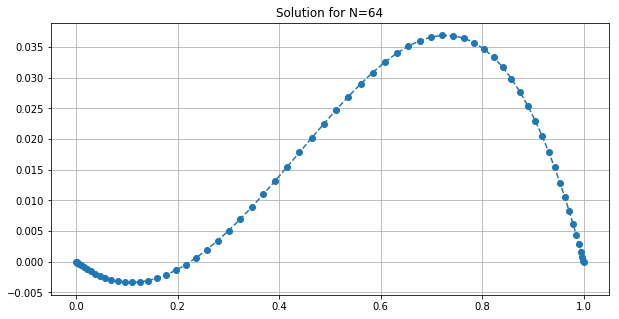

In [153]:
N = 64
K,x = K_approx(N)
f = rhs(x)
v = np.linalg.solve(K,f)

# and we add the boundary conditions
x = np.insert(x, 0, 1); x = np.append(x, 0)
v = np.insert(v, 0, 0); v = np.append(v, 0)

# solution
plt.figure(figsize=(10,5))
plt.plot(x, v, "o--")
plt.grid()
plt.title("Solution for N={0}".format(N))
plt.show()

#### References for `problem 4`

* Spectral Methods in Matlab, Lloyd N. Trefethen, Chapter 12: Integral and Quadrature Formulas